In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
import sys
from pathlib import Path
if IN_COLAB:
    !pip install open-clip-torch
    !pip install jaxtyping einops open-clip-torch ftfy regex timm

    !git clone https://github.com/niccobarto/token-opt-generator.git
    REPO_DIR = Path('/content/token-opt-generator')
    PERSONAL_PROJECT_DIR=Path('content/token-opt-generator/tester')
    TOKEN_OPT_DIR= REPO_DIR/"token-opt"
    sys.path.insert(0,str(TOKEN_OPT_DIR))
    sys.path.insert(0,str(REPO_DIR))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.2 MB/s eta 0:00:00
Cloning into 'token-opt-generator'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 166 (delta 37), reused 132 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (166/166), 26.73 MiB | 43.24 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [3]:
if IN_COLAB:
  !unzip "/content/inputs.zip"


Archive:  /content/inputs.zip
   creating: inputs/
   creating: inputs/clean/
   creating: inputs/clean/chair/
  inflating: inputs/clean/chair/sedia1.jpg  
  inflating: inputs/clean/chair/sedia3.jpg  
   creating: inputs/clean/cup/
  inflating: inputs/clean/cup/tazza1.jpg  
  inflating: inputs/clean/cup/tazzaa2.jpg  
   creating: inputs/clean/lamp/
  inflating: inputs/clean/lamp/lampada1.jpg  
  inflating: inputs/clean/lamp/lampada2.jpg  
   creating: inputs/clean/sofa/
  inflating: inputs/clean/sofa/divano1.jpg  
  inflating: inputs/clean/sofa/divano3.jpg  
   creating: inputs/clean/table/
  inflating: inputs/clean/table/tavolo1.jpg  
  inflating: inputs/clean/table/tavolo2.jpg  
   creating: inputs/clean/vase/
  inflating: inputs/clean/vase/vaso2.jpg  
  inflating: inputs/clean/vase/vaso3.jpg  
   creating: inputs/real/
   creating: inputs/real/chair/
  inflating: inputs/real/chair/sedia1.jpg  
  inflating: inputs/real/chair/sedia2.jpg  
   creating: inputs/real/cup/
  inflating: inp

In [4]:
BASE_DATA_DIR=Path("/content")
INPUTS_PATH=BASE_DATA_DIR/"inputs"
OUT_DIR=Path("/content/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
SCORES_FILE_PATH=OUT_DIR/"clip_score.txt"

print('BASE_DATA_DIR    =', BASE_DATA_DIR)
print('INPUTS_PATH      =', INPUTS_PATH)
print('OUT_DIR          =', OUT_DIR)
print('SCORES_FILE_PATH =', SCORES_FILE_PATH)

BASE_DATA_DIR    = /content
INPUTS_PATH      = /content/inputs
OUT_DIR          = /content/outputs
SCORES_FILE_PATH = /content/outputs/clip_score.txt


In [5]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms.v2.functional as tvf
import gc
from einops import rearrange

In [6]:
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [7]:
device = torch.device("cuda")

In [8]:
TTO_AVAILABLE=True

try:
    from tto.test_time_opt import(
    TestTimeOpt,
    TestTimeOptConfig,
    CLIPObjective,
    MultiObjective,
    SigLIPObjective
    )
    print("Token-Opt importato correttamente")
except Exception as e:
    TTO_AVAILABLE=False
    print("Errore nell'importazione di Token-Opt:", e)
print(TTO_AVAILABLE)

TESTER_AVAILABLE=True
try:
  from tester.ImageExtractor import Extractor
  import tester.ImageSaver as ImageSaver
  from tester.PromptConfigurator import PromptConfigurator
  print("Tester importato correttamente")
except Exception as e:
  TESTER_AVAILABLE=False
  print("Errore nell'importazione di Tester",e)
print(TESTER_AVAILABLE)

Token-Opt importato correttamente
True
Tester importato correttamente
True


## Methods for image/tensor conversion

In [9]:
def image_to_tensor(image:Image.Image, device=None):
  img = (1. / 255.) * torch.from_numpy(
      np.array(image).astype(np.float32)
  ).permute(2, 0, 1)
  img = tvf.resize(img, 256)
  img = tvf.center_crop(img, 256)
  img = img.unsqueeze(0)
  if device is not None:
      img = img.to(device)
  return img

def tensor_to_image(t: torch.Tensor) -> Image.Image:
    # Valori attesi in [0,1], su GPU o CPU
    t = t.detach().clamp(0, 1)

    # Se arriva [C,H,W], aggiungo la dim di batch -> [1,C,H,W]
    if t.ndim == 3:
        t = t.unsqueeze(0)
    elif t.ndim != 4:
        raise ValueError(f"tensor_to_image: tensore con {t.ndim} dimensioni non supportato")

    # [B,C,H,W] -> [H, B*W, C], uint8 su CPU
    img = Image.fromarray(
        rearrange((t * 255).to(dtype=torch.uint8, device="cpu"), "b c h w -> h (b w) c").numpy()
    )
    return img

## Mask generation

In [10]:
def generate_mask(img, x0, y0, w, h):
    N, _, H, W = img.shape
    xs = rearrange(torch.arange(W), "w -> () () () w")
    ys = rearrange(torch.arange(H), "h -> () () h ()")
    x1 = x0 + w
    y1 = y0 + h
    mask = torch.ones_like(img[:, :1, :, :])
    mask[(x0 < xs) & (xs < x1) & (y0 < ys) & (ys < y1)] = 0
    return mask.expand_as(img)

## Set up objective functions

### Classe ReconstructionObjective

In [11]:
import torch.nn as nn

import torch
import torch.nn as nn

class ReconstructionObjective(nn.Module):
    def __init__(self, masked_img, mask):
        """
        masked_img: immagine con il buco, [B, C, H, W]
        mask:       maschera binaria (1 = area da ricostruire), [B, 1, H, W] o [B, C, H, W]
        """
        super().__init__()
        self.masked_img = masked_img
        self.mask = mask

    def forward(self, img):
        # differenza assoluta solo dentro la maschera
        diff = (img - self.masked_img).abs() * self.mask
        # media sulla regione mascherata
        loss = diff.sum(dim=(1,2,3)) / (self.mask.sum(dim=(1,2,3)) + 1e-8)
        return loss



In [185]:
clip_objective_weight=2.0
reconstruction_objective_weight=1.0
clip_objective=CLIPObjective(num_augmentations=8, cfg_scale=1.2)
reconstruction_objective = ReconstructionObjective(None, None)

objective=MultiObjective(
    [
        clip_objective,
        reconstruction_objective,
    ],
    [
        clip_objective_weight,
        reconstruction_objective_weight,
    ]).to(device)


## Set up TTO configuration and TTO

In [186]:
tto_config = TestTimeOptConfig(
    num_iter=601,
    ema_decay=0.995,
    lr=3e-2,
    enable_amp=False,
    reg_weight=1e-2,
    token_noise=5e-3,
    reg_type="zero",
)
tto = TestTimeOpt(tto_config, objective).to(device)

# Run Optimization

### Load image and create masked image and mask

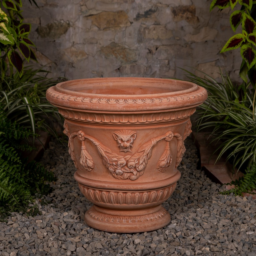

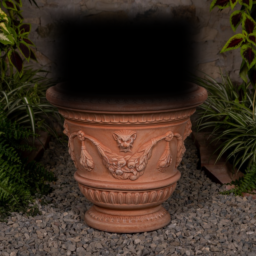

In [187]:
image:Image.Image=Image.open(INPUTS_PATH/"real/vase/vaso1.jpg").convert("RGB")
img=image_to_tensor(image, device)
mask=generate_mask(img, x0=50, y0=10, w=150, h=100)
mask = tvf.gaussian_blur(mask, 51)
mask = torch.clamp(mask, 0., 1.)
masked_img = mask * img
display(tensor_to_image(img))
display(tensor_to_image(masked_img))

### TokenResetter
Durante l’ottimizzazione test-time (tto(...)), il modello non genera l’immagine con un forward classico tipo diffusion, ma:


1.   parte da un insieme di token latenti (1D, compressi dal tokenizer TiTok),
2.   li ottimizza iterativamente per minimizzare una loss di obiettivo (es. CLIPObjective, ReconstructionObjective, ecc.),
3. dopo ogni step, decodifica i token per ottenere un’immagine, calcola la loss e aggiorna i token.

Il problema nasce nell’inpainting: se lasci che i token vengano ottimizzati liberamente su tutta l’immagine, anche le zone fuori dalla maschera (cioè quelle che dovrebbero restare identiche all’originale) vengono corrotte nel tempo.
Il TokenResetter serve esattamente a evitare questo

In [15]:
class TokenResetter:
    def __init__(self, titok, masked_img, mask, reset_period=5):
        self.titok = titok
        self.masked_img = masked_img
        self.mask = mask
        self.reset_period = reset_period

    @torch.no_grad()
    def __call__(self, info):
        if info.i % self.reset_period != 0:
            return
        dec_reset = (1. - self.mask) * info.img + self.masked_img
        return self.titok.encoder(dec_reset, self.titok.latent_tokens)

## Callback

In [16]:
class InpaintingPlotter:
    def __init__(self, masked_img, mask):
        self.masked_img = masked_img
        self.mask = mask

    def __call__(self, info):
        if info.i % 50 == 0:
            print(f"i = {info.i}")
            img = tto.decode(info.tokens).clamp(0., 1.)
            img_blended = (1. - self.mask) * img + self.masked_img
            display(tensor_to_image(*img_blended))


## Loop principale

In [188]:
prompt = "a photo of a vase with red poppies coming out of it"

objective.objectives[0].prompt=prompt
objective.objectives[1].masked_img=masked_img
objective.objectives[1].mask=1-mask


input


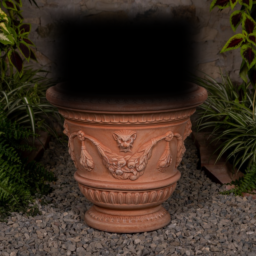

i = 0


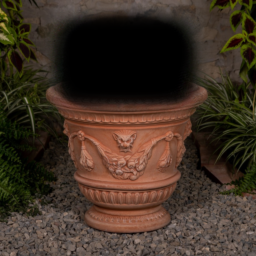

i = 50


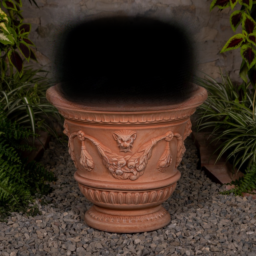

i = 100


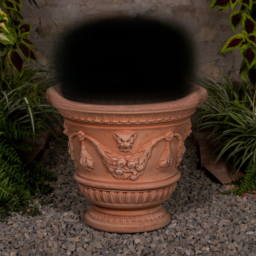

i = 150


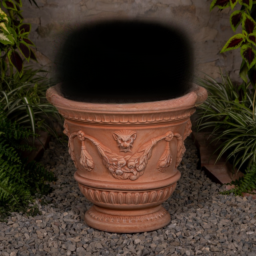

i = 200


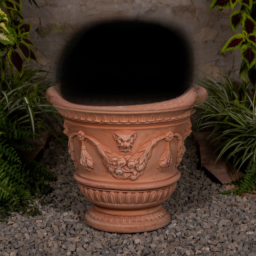

i = 250


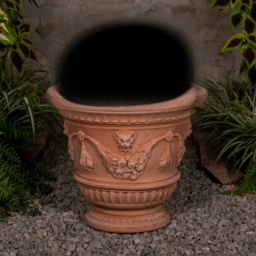

i = 300


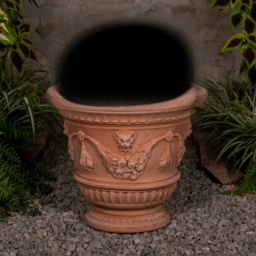

KeyboardInterrupt: 

In [189]:
print("input")
display(tensor_to_image(masked_img))
img_opt,loss = tto(
    seed=masked_img,
    callback=InpaintingPlotter(masked_img, mask),
    token_reset_callback=TokenResetter(tto.titok, masked_img, mask)
  )

In [184]:
"""
import gc, torch, os

for name in ["tto", "objective"]:   # aggiungi qui eventuali altri handler GPU
    if name in globals():
        del globals()[name]

gc.collect()
torch.cuda.empty_cache()
